# Boosting and Adaboost

## Learning objectives
- implement
    - your first boosted model - Adaboost
- understand
    - the ideas behind boosting
    - how to apply boosting to decision trees and implement Adaboost

## Intro - What is boosting?

Boosting is an ensemble method that combines a sequence of weak classifiers which are fit on successively modified versions of the data, which increasingly prioritise examples misclassified by the previous model.

## Bagging vs boosting

Like bagging, boosting makes an ensemble of weak learners (models that do barely better than random guessing) to form a single strong learner.
Bagging simply combined the predictions of different models that were fit to the same data independently (trained in parallel).
Differently, boosting combines the predictions of different models that were fit dependending on how well the previous model performed (trained in sequence).

![](images/bagging_vs_boosting.jpg)

# AdaBoost

Boosting algorithms vary in how they adjust the weights of the examples that are samples into each successive bootstrapped dataset, and in how they weight the contribution of each hypothesis to the final prediction.
AdaBoost is the most popular boosting algorithm.
It is used for classification problems.
The name AdaBoost is short for **adaptive boosting**.

AdaBoost is a classification algorithm.

In AdaBoost, the example labels are coded as $Y=-1$ for examples in the negative class, and $Y=+1$ for examples in the positive class.

In AdaBoost, each model is a very weak classification tree with a depth of 1.
We call such limited trees "stumps".
AdaBoost converts many "weak learners" into a single "strong learner" by combining these stumps.

AdaBoost combines the predictions of all of the classifiers to make a prediction by evaluating:

![](images/boosting_hypothesis.jpg)

This is simply the sign of a weighted combination of predictions.

### But where do the weights for each model come from?

The models are applied sequentially, and because of their limited capacity, each of them is likely to make some mistake.

The error of a model is calculated as:

![](images/err_l.jpg)

The weight of the prediction of each model is then computed based on the error rate given by:

![](images/boosting_model_weight.PNG)

Large negative model weight = your model sucks.
Large positive model weight = your model rocks.
Zero model weight = your model is as good as a random guessing.

The weights of each example are increased if they were incorrectly classified by the previous model, and decreased if they were already classified correctly.

For the first model in the sequence, the importance of classifying each example correctly is equal.
That is, we weight the error contribution for each example in the dataset by the same equal amount, $w_i= \frac{1}{m}$.
For the next weighted sample from the dataset, 
To sample the bootstrapped dataset for the next model in the sequence to be trained on, we set the weight of each example to:

![](images/boosting_example_weight.jpg)

Let's consider what this means for a variety of cases:
- positive model weight and correct classification: weight of example pushed down
- negative model weight and correct classification: weight of example pushed up
- positive model weight and incorrect classification: weight of example pushed up
- negative model weight and incorrect classification: weight of example pushed down

### What does this weight calculation do?
Most examples may be correctly classified by our very simple weak classifier stumps.
It is the edge cases that need extra attention.
So sequentially, the importance of examples which are not able to be classified correctly by the previous model are increased and vice versa.
Models later in the sequence hence focus on harder to classify examples.
As depth increases, the importance of easy to classify examples dimishes and tends to zero.
This effectively removes them from the dataset, leaving less examples for the later models to classify.
Less examples are separable with a simpler decision boundary.

The weighting of each model prediction serves to increase the influence of models that correctly classify examples from the bootstrapped dataset which they are trained on.

## Adaboost algorithm outline

- for however many models in your sequence
    - fit the model as usual
    - compute the proportion of incorrect predictions weighted by the corresponding example's weight
    - use this to compute the model weight
    - update each example's weight so that 

accuracy: 100.0


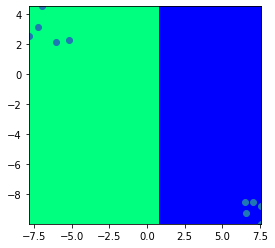

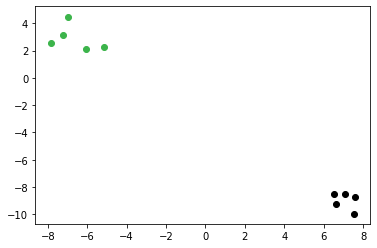

[1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876, 1.0515679367242876]


In [14]:
import sklearn.tree
import sys
sys.path.append('..') # add utils file to path
from utils import get_classification_data, calc_accuracy, visualise_predictions, show_data
import numpy as np
import matplotlib.pyplot as plt
import json

class AdaBoost:
    def __init__(self, n_layers=20):
        self.n_layers = n_layers
        self.models = [] # init empty list of models

    def calc_model_error(self, predictions, labels, example_weights):
        """Compute classifier error rate"""
        diff = predictions == labels
        diff = diff.astype(float)
        diff *= example_weights
        # weighted_diffs = weights * diff
        return np.mean(diff)

    def encode_labels(self, labels):
        labels[labels == 0] = -1
        labels[labels == 1] = +1
        return labels

    def calc_model_weight(self, error, delta=0.01):
        z = (1 - error) / (error + delta) + delta
        return 0.5 * np.log(z)

    def update_weights(self, predictions, labels, model_weight):
        weights = np.exp(- model_weight * predictions * labels)
        weights /= np.sum(weights)
        return weights

    def fit(self, X, Y):
        features = X
        labels = self.encode_labels(Y)
        example_weights = np.full(len(X), 1/len(X)) # assign initial importance of classifying each example as uniform and equal
        for layer_idx in range(self.n_layers):
            model = sklearn.tree.DecisionTreeClassifier(max_depth=1)
            model.fit(features, labels)
            self.models.append(model)
            predictions = model.predict(X)
            model_error = self.calc_model_error(predictions, labels, example_weights)
            model_weight = self.calc_model_weight(model_error)
            model.weight = model_weight
            example_weights = self.update_weights(predictions, labels, model_weight)
            # print(f'trained model {layer_idx}')
            # print()

    def predict(self, X):
        prediction = np.zeros(len(X))
        for model in self.models:
            prediction += model.weight * model.predict(X)
        return np.sign(prediction)

    def __repr__(self):
        return json.dumps([m.weight for m in self.models])
        return json.dumps([
            {
                'weight': model.weight
            }
            for model in self.models
        ], indent=4)

X, Y = get_classification_data(sd=1)
adaBoost = AdaBoost()
adaBoost.fit(X, Y)
predictions = adaBoost.predict(X)
print(f'accuracy: {calc_accuracy(predictions, Y)}')
visualise_predictions(adaBoost.predict, X)
show_data(X, Y)
print(adaBoost)

model 0
accuracy: 83.0
weights: [2.0, 2.26, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28]


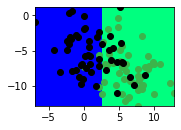


model 1
accuracy: 83.0
weights: [2.0, 2.26, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28]


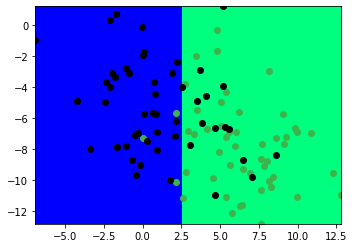


model 2
accuracy: 83.0
weights: [2.0, 2.26, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28, 2.28]


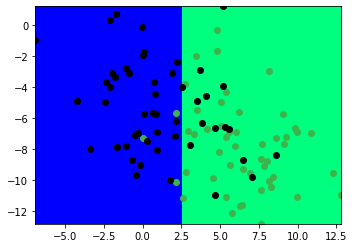

In [15]:
fig = plt.figure()
fig.add_subplot(211)
X, Y = get_classification_data(sd=3, m=100)

for i in range(3):
    adaBoost = AdaBoost()
    adaBoost.fit(X, Y)
    predictions = adaBoost.predict(X)
    print(f'model {i}')
    print(f'accuracy: {calc_accuracy(predictions, Y)}')
    print(f'weights: {[ round(m.weight, 2) for m in adaBoost.models]}')
    visualise_predictions(adaBoost.predict, X, Y)
    # show_data(X, Y)
    print()

## Sklearn implementation

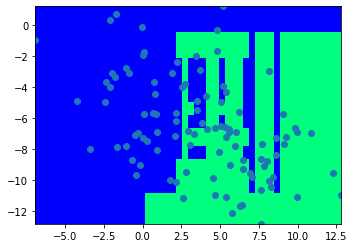

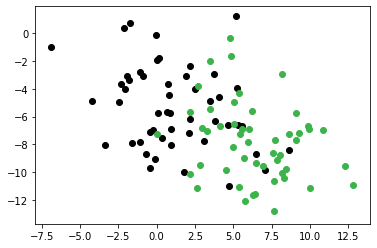

In [16]:
import sklearn.ensemble

adaBoost = sklearn.ensemble.AdaBoostClassifier()
adaBoost.fit(X, Y)
predictions = adaBoost.predict(X)
calc_accuracy(predictions, Y)
visualise_predictions(adaBoost.predict, X)
show_data(X, Y)

In this notebook we have only considered AdaBoost for binary classification. See [here](https://web.stanford.edu/~hastie/Papers/samme.pdf) for the (significantly more involved) details of how this algorithm can be adapted to multiclass classification problems.

## Summary
- Boosting is a technique where we sequentially adjust the prediction from a model by shifting it by proportionally to the prediction from the following model in the sequence
- AdaBoost is an "adaptive" boosting algorithm
- The weight for 

## Challenges
- perform adaptive boosting with a model that is not a decision tree
- adapt the above code to work for a regression model